In [64]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
from tqdm import tqdm
import wandb
from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f, LogLevel


from torch_openpose.body import Body
from torch_openpose import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def wandb_init(name):
    run = wandb.init(
        project = "mts_texture_test", 
        reinit = True,
        name = name,
        config={
            "steps": 100,
            "learning_rate": 0.2,
            "optimizer": "Adam",
            "noise_width": 200,
            "noise_height": 400,
        }
    )
    
    return run 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 367.5, -0.5)

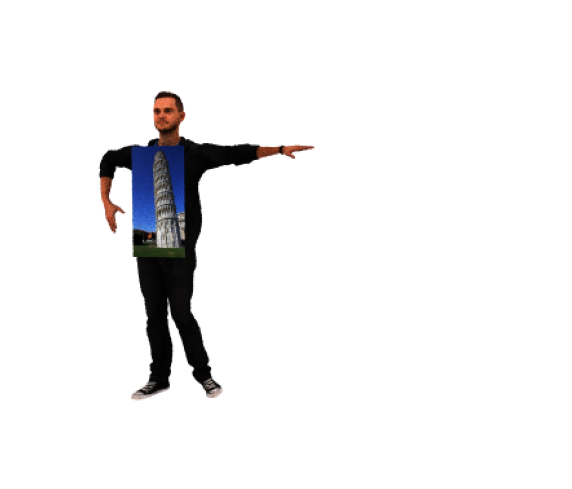

In [73]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
origal_file_name = 'pose_scene/pisa.jpg'
origal_texture = cv2.imread(origal_file_name)
SPP = 24
noise_resolution  = np.array([200, 400])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


thread = Thread.thread()
thread.file_resolver().append('pose_scene')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)

scene = load_file('pose_scene/scene_image_texture.xml')
params = traverse(scene)

# Render a reference image (no derivatives used yet)
rendering_torch_ref = render_torch(scene, spp=SPP)

# make torch RGB to BGR
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch_ref[:, :, PERMUTE_BGR]
# permute and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

canvas = rendering_torch_BGR.cpu().detach().numpy() 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.axis('off')

In [74]:
run = wandb_init(origal_file_name)
noise_resolution  = np.array([200, 400])


diff_parameter = 'rect.bsdf.reflectance.data'
params.keep([diff_parameter])
params[diff_parameter] = [0] * len(params[diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()
REGULARIZATION = torch.tensor(1e-7, device=device)

# set up optimizer
opt = torch.optim.Adam(params_torch.values(), lr=run.config.learning_rate)
objective = torch.nn.MSELoss()


for step in tqdm(range(run.config.steps)):
    if step % 50 ==  0:
        write_bitmap('output/image_texture_%03i.png' % step, params_torch[diff_parameter], noise_resolution)
    opt.zero_grad()

    # render image
    # maybe add malloc_trim=True if memory issues
    cur_rednering_torch = render_torch(scene, params=params, unbiased=True, spp=SPP, **params_torch)
    
    ob_val_heat = objective(rendering_torch_ref, cur_rednering_torch)
    y = params_torch[diff_parameter].view(noise_resolution[1], noise_resolution[0], 3)
    y = y.permute((2, 0, 1))
    ob_val = ob_val_heat + REGULARIZATION * (
        torch.sum(torch.abs(y[:, :, :-1] - y[:, :, 1:])) + 
        torch.sum(torch.abs(y[:, :-1, :] - y[:, 1:, :]))
    )
    
    # calc gradient
    ob_val.backward()
    
    # take a step in gradient direction
    opt.step()
    
    # log the loss
    wandb.log({'loss': ob_val.item()}, step=step)


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

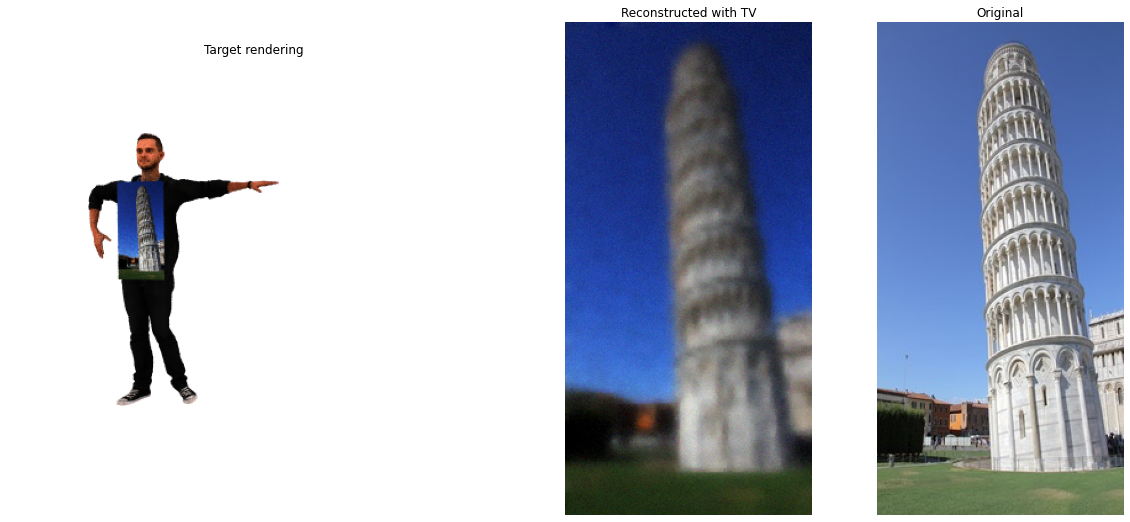

In [75]:
canvas = params_torch[diff_parameter].detach().cpu().numpy()
canvas = canvas.reshape(noise_resolution[1], noise_resolution[0], -1)


rendering_canvas = rendering_torch_BGR.cpu().detach().numpy() 

fig = plt.figure(figsize=(20, 60))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

ax = plt.subplot(gs[0])
ax.imshow(rendering_canvas[:, :, [2, 1, 0]])
ax.axis('off')
ax.set_title('Target rendering')

ax = plt.subplot(gs[1])
ax.imshow(canvas)
ax.axis('off')
ax.set_title('Reconstructed with TV')

ax = plt.subplot(gs[2])
ax.imshow(origal_texture[:, :, [2, 1, 0]])
ax.axis('off')
ax.set_title('Original')